# Νευρωνικά Δίκτυα και Βαθιά Μάθηση
## 1η Εργαστηριακή Άσκηση
##Χαρίδημος Παπαδάκης el20022

Mount το google drive. Το κάνουμε αυτό για έχουμε πρόσβαση στα python modules που χρειαζόμαστε.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Το συνδέουμε με το folder του συγκεκριμένου εργαστηρίου

In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Lab_DL_ex1')

Εγκαθιστούμε τις απαραίτητες βιβλιοθήκες

In [3]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [4]:
!{sys.executable} -m pip install matplotlip

### Οδηγίες

Σε αυτή την εργασία θα κάνετε τα εξής:
1. Δοκιμή τουλάχιστον των 3 καλύτερων συνδυασμών των παραμέτρων width και depth του Δικτύου wideResNet σύμφωνα με αυτά που προτείνονται και στο paper (results with moderate data augmentation)

2. Regularization. Το δίκτυο έχει μηχανισμό ομαλοποίησης (Dropout). Δοκιμάστε να προσθέσετε το Dropout (παράμετρος droprate) όπως αναφέρει το paper και καταγράψτε τα αποτελέσματα για τα παραπάνω μοντέλα.

3. Κρατώντας τις παραμέτρους του δικτύου με τα καλύτερα αποτελέσματα (load best model από το 1 και 2) θα κάνετε test στο CIFAR-C. Έπειτα, θα εφαρμόσετε τη μέθοδο mixup (συμπληρώστε τον κώδικα στο κελί με το CifarDataset) κάντε εκ νέου την εκπαίδευση και καταγράψτε τα αποτελέσματα.

4. (Bonus) Κάντε επίσης ένα plot των confidence scores (softmax predictions) και συγκρίνετε το με το αντίστοιχο plot όταν το μοντέλο δεν είχε mixup. Τι παρατηρείτε?

Tip: Για το κάθε πείραμα (training) μην το τρέξετε πάνω από 20 εποχές


Ορισμένα κελιά κώδικα παρέχονται για εσάς σε αυτό το notebook. Θα πρέπει να αποφύγετε την επεξεργασία του παρεχόμενου κώδικα και να φροντίσετε να εκτελέσετε τα κελιά για να αποφύγετε απροσδόκητα σφάλματα. Ορισμένα κελιά ξεκινούν με τη γραμμή:

΄#### GRADED CELL ####`
Αυτά θα βαθμολογηθούν. Φρόντιστε για κάθε κελί να δικαιολογείτε με σχόλια τις επιλογές σας.


### Ας ξεκινήσουμε!

Θα ξεκινήσουμε την εκτέλεση ορισμένων imports και τη φόρτωση του συνόλου δεδομένων. Μην επεξεργαστείτε τα υπάρχοντα imports στο παρακάτω κελί. Εάν θέλετε να κάνετε περαιτέρω imports, θα πρέπει να τα προσθέσετε εδώ.

Φορτώνουμε τις απαραίτητες βιβλιοθήκες

In [5]:
import numpy as np
import time
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torch.nn as nn
import torch.optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import pickle
import random
from wideresnet import WideResNet
import logging
import shutil
import os
import matplotlib.pyplot as plt



torch.manual_seed(0)
np.random.seed(0)


In [6]:
data_dir = "/content/drive/My Drive/Lab_DL_ex1/data"




Δημιουργία φακέλου στο οποίο θα κρατάμε τα log files των πειραμάτων

In [7]:
exp_name = "/content/drive/My Drive/Lab_DL_ex1/Lab_1_DL_wrn_log"


exp_dir = os.path.join('Cifar', exp_name)

if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)


logfile = open(os.path.join(exp_dir, 'log'), 'w')

Στο παρακάτω κελί θα δημιουργήσουμε το train και validation loader χρησιμοποιώντας τη συνάρτηση construct_datasets

In [8]:
def construct_datasets(data_dir, batch_size):
    def data2loader_train(tr_data):
        train_loader = torch.utils.data.DataLoader(
            tr_data,
            batch_size=batch_size,
            shuffle=True)
        return train_loader

    def data2loader_test(te_data):
        test_loader = torch.utils.data.DataLoader(
            te_data,
            batch_size=batch_size,
            shuffle=False)

        return test_loader

    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    train_transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(), normalize])

    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])

    train_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=True, transform=train_transform, download=True)
    test_data = datasets.CIFAR10(
        os.path.join(data_dir, 'cifar'), train=False, transform=test_transform, download=True)
    print("Train set number of items ", len(train_data))
    print("Val set number of items ", len(test_data))

    return data2loader_train(train_data), data2loader_test(test_data)

In [9]:
batch_size = 128
train_loader, val_loader = construct_datasets(data_dir, batch_size)

Files already downloaded and verified
Files already downloaded and verified
Train set number of items  50000
Val set number of items  10000


Σε αυτό το σημείο θα ορίσουμε το μοντέλο (Wide Residual Network), τη loss function και τον scheduler αυτής και τον optimizer

In [10]:
def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)


def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))

def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [11]:
def test_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    params = list(net.parameters())
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            targets = targets.cuda(non_blocking=True).long()
            images = images.cuda(non_blocking=True).float()
            logits = net(images)

            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)


def test_c_cifar(net):
    """Evaluate network on given corrupted dataset."""
    base_path = '/content/drive/My Drive/Lab_DL_ex1/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])
    test_data = datasets.CIFAR10(
        '/content/drive/My Drive/Lab_DL_ex1/data/cifar/', train=False, transform=test_transform)
    corruption_accs = []
    Weather_accs = []
    Blur_accs = []
    Noise_accs = []
    Digital_accs = []
    weather_corr = ['snow', 'frost', 'fog']
    blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
    noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
    digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')[-10000:]  # take the level 5 severity only
        #pdb.set_trace()
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False,
            #num_workers=4,
            pin_memory=True)
        test_loss, test_acc = test_cifar(test_loader, net)
        corruption_accs.append(test_acc)
        if corruption in weather_corr:
            Weather_accs.append(test_acc)
        elif corruption in blur_corr:
            Blur_accs.append(test_acc)
        elif corruption in noise_corr:
            Noise_accs.append(test_acc)
        elif corruption in digital_corr:
            Digital_accs.append(test_acc)


        #print('{}\n\tTest Loss {:.3f} | Test Acc {:.3f}'.format(
        #    corruption, test_loss, test_acc))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Weather', np.mean(np.array(Weather_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Blur', np.mean(np.array(Blur_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Noise', np.mean(np.array(Noise_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Digital', np.mean(np.array(Digital_accs))))
    all_accs = []
    all_accs.append(np.mean(np.array(Weather_accs)))
    all_accs.append(np.mean(np.array(Blur_accs)))
    all_accs.append(np.mean(np.array(Noise_accs)))
    all_accs.append(np.mean(np.array(Digital_accs)))

    return np.mean(np.array(all_accs))



In [12]:

def train_model(num_iters, train_loader, model):

  # Train loop

  for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()

    params = list(model.parameters())
    output = model(input)
    ce_loss = criterion(output, target)
    #ce_loss = criterion(output, target)


    optimizer.zero_grad()
    ce_loss.backward()
    optimizer.step()
    scheduler.step()


      # measure accuracy and record loss
    prec1 = accuracy(output, target, topk=(1,))[0]
    losses.update(ce_loss.data.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))



    if t % print_freq == 0 and t >= print_freq:

        loss1, prec1 = test_cifar(val_loader, model)
        #print("Epoch ", epoch)
        print("Validation set acc", prec1)
        logfile.write('validation set acc: ' + str(prec1) + '\n')
        #print('Average Cifar-C accuracy {}'.format(test_c_cifar(model)))




  # validate_all(model, args.data_dir, exp_name, args.batch_size, logfile, t, kwargs)

  print('Cifar accuracy {}'.format(test_cifar(val_loader, model)))
  logging.info(f'avg acc {test_cifar(val_loader, model)}')
  logfile.write(str(t) + ' Val acc: ' + str(test_cifar(val_loader, model)) + '\n')
  # logfile.close()





Ζητούμενο 1 και 2.

Στο παρακάτω κελί φαίνεται ένα παράδειγμα ενός wide residual network.
Διαβάζοντας το paper θα πρέπει να βρείτε τις παραμέτρους για τα 3 καλύτερα μοντέλα που προτείνονται στο paper.

Χρησιμοποιείστε το παρακάτω κελί ως template και σχολιάστε τις επιλογές σας σε markdown κελί κάνοντας αναφορά στο paper.

Τα 3 καλύτερα μοντέλα που προτείνονται στο paper (table 5,  test error of different methods on CIFAR-10 moderate data augmentation and mean/std normalzation) είναι:

depth - k (k : widening factor)

40 - 4

16 - 8

28 - 10

Παρατηρούμε πως και τα 3 μοντέλα, έχουν πολύ υψηλό accuracy, γεγονός που συμφωνεί με τη θεωρητική ανάλυση παρόλο που χρησιμοποιούμε μικρότερο αριθμό εποχών. Επιπλέον, τα μοντέλα κατατάσσονται σε φθίνουσα σειρά (με κριτήριο το accuracy) ως εξής:

28 - 10

16 - 8

40 - 4

Μπορούμε να επιβεβαιώσουμε, λοιπόν, τη διαπίστωση του paper πως το widening βελτιώνει την επίδοση των RNNs διαφορετικού βάθους. Δεν ελέγξαμε ωστόσο, μέχρι ποιο σημείο η αύξηση του βάθους και του πλάτους οδηγεί σε καλύτερα αποτελέσματα. Στο paper αναφέρεται πως αυτό συμβαίνει μέχρι το σημείο που ο αριθμός των παραμέτρων γίνεται πολύ μεγάλος και απαιτείται έντονη κανονικοποίηση. Επιπλέον, τα WRNs μπορούν να εκπαιδευθούν με επιτυχία, με διπλάσιο αριθμό κάτι που θα απαιτούσε διπλάσιο βάθος στα κλασικά deep RNNs και θα καθιστούσε πολύ ακριβή την εκπαίδευση.  

Ας εξετάσουμε τώρα την επίδραση του Dropout.  Το Dropout τυχαία θέτει ένα μέρος των μονάδων εισόδου σε 0 σε κάθε ενημέρωση κατά τη διάρκεια της εκπαίδευσης, βοηθώντας στην πρόληψη του overfitting. Αυτή η τυχαιότητα αναγκάζει το δίκτυο να μάθει πιο robust χαρακτηριστικά που είναι χρήσιμα σε συνδυασμό με πολλά διαφορετικά τυχαία υποσύνολα άλλων νευρώνων.

Παρακάτω φαίνεται πως για ίδιο αριθμό εποχών το προτεινόμενο από το paper dropout (0.3) δεν βελτιώνει το accuracy, αλλά μειώνει το συνολικό cross entropy loss.

Ενώ το dropout σχεδιάστηκε για να ενισχύσει το generalization (άρα και το accuracy του test set), αυτό δεν είναι εγγυημένο. Η αποτελεσματικότητα του dropout στη βελτίωση του testing accuracy εξαρτάται από παράγοντες όπως η αρχιτεκτονική του δικτύου, η ποσότητα των δεδομένων εκπαίδευσης και ο αριθμός των εποχών.

Αν και το accuracy μπορεί να μη βελτιωθεί (ή μπορεί ελαφρώς να επιδεινωθεί σε κάποιες περιπτώσεις), το cross entropy loss σε όλες τις κλάσεις μπορεί να μειωθεί. Αυτή η μείωση συμβαίνει επειδή το dropout βοηθά στη διαχείριση του confidence των προβλέψεων, μειώνοντας την πιθανότητα ακραίων τιμών πρόβλεψης που είναι πολύ λανθασμένες, οι οποίες τιμωρούνται σημαντικά από τη συνάρτηση cross entropy. Πραγματοποιείται ένα trade off μεταξύ accuracy και ενός πιο robust μοντέλου που γενικεύει καλύτερα σε unseen data, γεγονός που αποτυπώνεται ως βελτιωμένα loss metrics.

In [ ]:
# Model Parameters cell

num_epochs = 20

num_iters = 391 * num_epochs  # number of total epochs to run

batch_size = 128

print_freq = 391 # evaluation frequency (and log) (every epoch)

layers = 40  # total number of layers of wrn (wide residual network)
num_classes = 10  # Number of classes of th CIFAR dataset
widen_factor = 2
droprate =  0.0 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)

model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

train_model(num_iters, train_loader, model)

Validation set acc 0.5388
Validation set acc 0.5834
Validation set acc 0.7238
Validation set acc 0.7804
Validation set acc 0.7256
Validation set acc 0.6999
Validation set acc 0.7881
Validation set acc 0.7878
Validation set acc 0.8212
Validation set acc 0.8369
Validation set acc 0.8297
Validation set acc 0.8637
Validation set acc 0.8828
Validation set acc 0.8836
Validation set acc 0.8996
Validation set acc 0.9072
Validation set acc 0.9136
Validation set acc 0.9186
Validation set acc 0.9202
Cifar accuracy (0.0020523578733205794, 0.921)


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 1 without dropout

num_epochs = 20

num_iters = 391 * num_epochs  # number of total epochs to run

batch_size = 128

print_freq = 391 # evaluation frequency (and log) (every epoch)

layers =  40 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 4
droprate = 0  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model)

Validation set acc 0.6374
Validation set acc 0.6438
Validation set acc 0.7821
Validation set acc 0.7953
Validation set acc 0.7841
Validation set acc 0.8064
Validation set acc 0.8009
Validation set acc 0.8336
Validation set acc 0.8477
Validation set acc 0.8294
Validation set acc 0.8485
Validation set acc 0.8725
Validation set acc 0.8717
Validation set acc 0.9015
Validation set acc 0.8998
Validation set acc 0.9161
Validation set acc 0.9221
Validation set acc 0.9294
Validation set acc 0.9304
Cifar accuracy (0.0018531367879360914, 0.9306)


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 1

layers =  40 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 4
droprate = 0.3  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model)

Validation set acc 0.515
Validation set acc 0.6632
Validation set acc 0.7503
Validation set acc 0.7681
Validation set acc 0.7547
Validation set acc 0.7767
Validation set acc 0.8152
Validation set acc 0.8235
Validation set acc 0.8044
Validation set acc 0.8429
Validation set acc 0.8415
Validation set acc 0.873
Validation set acc 0.8834
Validation set acc 0.8921
Validation set acc 0.9048
Validation set acc 0.9143
Validation set acc 0.9223
Validation set acc 0.9233
Validation set acc 0.928
Cifar accuracy (0.0017393671300262213, 0.928)


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 2 without dropout

layers =  16 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 8
droprate =  0 #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

train_model(num_iters, train_loader, model)

Validation set acc 0.5661
Validation set acc 0.6758
Validation set acc 0.6982
Validation set acc 0.7741
Validation set acc 0.7304
Validation set acc 0.8059
Validation set acc 0.807
Validation set acc 0.7894
Validation set acc 0.8269
Validation set acc 0.859
Validation set acc 0.8621
Validation set acc 0.8778
Validation set acc 0.8829
Validation set acc 0.9003
Validation set acc 0.9182
Validation set acc 0.9258
Validation set acc 0.9272
Validation set acc 0.9312
Validation set acc 0.9313
Cifar accuracy (0.0017375309705734254, 0.9316)


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 2

layers =  16 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 8
droprate = 0.3  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

train_model(num_iters, train_loader, model)

Validation set acc 0.5784
Validation set acc 0.5483
Validation set acc 0.7491
Validation set acc 0.7579
Validation set acc 0.8002
Validation set acc 0.7855
Validation set acc 0.8189
Validation set acc 0.8327
Validation set acc 0.8167
Validation set acc 0.849
Validation set acc 0.8587
Validation set acc 0.8802
Validation set acc 0.8776
Validation set acc 0.8987
Validation set acc 0.9096
Validation set acc 0.9161
Validation set acc 0.9245
Validation set acc 0.9277
Validation set acc 0.93
Cifar accuracy (0.001707649802789092, 0.9307)


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 3 without dropout

layers =  28 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = 0  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model)

Validation set acc 0.6046
Validation set acc 0.6378
Validation set acc 0.7209
Validation set acc 0.7752
Validation set acc 0.7736
Validation set acc 0.8402
Validation set acc 0.8547
Validation set acc 0.8641
Validation set acc 0.829
Validation set acc 0.8676
Validation set acc 0.8749
Validation set acc 0.8915
Validation set acc 0.9011
Validation set acc 0.9062
Validation set acc 0.9166
Validation set acc 0.93
Validation set acc 0.9334
Validation set acc 0.9379
Validation set acc 0.9399
Cifar accuracy (0.0016928119763731956, 0.9396)


In [ ]:
#### GRADED CELL ####

# Complete the following parameters and run the cell

# Model Parameters cell 3

layers =  28 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = 0.3  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)


model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))


train_model(num_iters, train_loader, model)

Validation set acc 0.6121
Validation set acc 0.6232
Validation set acc 0.6966
Validation set acc 0.6712
Validation set acc 0.7183
Validation set acc 0.827
Validation set acc 0.8424
Validation set acc 0.8336
Validation set acc 0.8534
Validation set acc 0.8663
Validation set acc 0.8663
Validation set acc 0.8633
Validation set acc 0.8999
Validation set acc 0.9021
Validation set acc 0.9198
Validation set acc 0.9236
Validation set acc 0.9297
Validation set acc 0.9334
Validation set acc 0.9356
Cifar accuracy (0.0016499050065875054, 0.9355)


# Μέρος 3
## WRN με MIxup augmentation στο CIFAR-C


Στις περισσότερες επιτυχημένες εφαρμογές τα νευρωνικά δίκτυα (large deep neuaral networks) μοιράζονται δύο κοινά σημεία. Πρώτον, είναι
εκπαιδευμένοι ώστε να ελαχιστοποιούν το μέσο σφάλμα τους στα δεδομένα εκπαίδευσης, ένας κανόνας εκμάθησης γνωστός και Empirical Risk Minimazation (ERM) (Vapnik, 1998). Δεύτερον, το μέγεθος αυτών των νευρωνικών δικτύων  κλιμακώνεται γραμμικά με τον αριθμό των παραδειγμάτων εκπαίδευσης.

Παραδόξως, ένα κλασικό αποτέλεσμα στη θεωρία μάθησης (Vapnik & Chervonenkis, 1971) μας λέει ότι η
η σύγκλιση του ERM είναι εγγυημένη εφόσον το μέγεθος της μηχανής εκμάθησης (π.χ.
δίκτυο) δεν αυξάνεται με τον αριθμό των δεδομένων εκπαίδευσης. Εδώ, το μέγεθος μιας μηχανής εκμάθησης μετριέται ως προς τον αριθμό των παραμέτρων το.

Αυτή η αντίφαση αμφισβητεί την καταλληλότητα του ERM να εκπαιδεύει τα τρέχοντα μοντέλα νευρωνικών δικτύων μας. Από τη μία πλευρά, ο ERM επιτρέπει σε μεγάλα νευρωνικά δίκτυα να απομνημονεύουν
(αντί να γενικεύσουμε από) τα δεδομένα εκπαίδευσης ακόμη και με την παρουσία ισχυρής ομαλοποίησης (Dropout). Επίσης, α νευρωνικά δίκτυα που έχουν εκπαιδευτεί με ERM αλλάζουν δραστικά τις προβλέψεις τους όταν αξιολογούνται
παραδείγματα με μικρές διαφορές από την κατανομή της εκπαίδευσης (adversarial examples). Αυτά τα στοιχεία υποδηλώνουν ότι ο ERM δεν είναι σε θέση να εξηγήσει ή να παράσχει γενίκευση στις δοκιμές κατανομές που διαφέρουν ελάχιστα από τα δεδομένα εκπαίδευσης. Ωστόσο, ποια είναι η εναλλακτική του ERM;

Η μέθοδος επιλογής για εκπαίδευση σε παρόμοια αλλά διαφορετικά παραδείγματα με τα δεδομένα εκπαίδευσης είναι γνωστή ως δεδομένα επάυξησης (Data augmentation) (Simard et al., 1998), Vicinal Risk Minimization (VRM)
(Chapelle et al., 2000). Στο VRM, απαιτείται ανθρώπινη γνώση για να περιγράψει μια γειτονιά γύρω από κάθε παράδειγμα στα δεδομένα εκπαίδευσης. Στη συνέχεια, μπορούν να αντληθούν πρόσθετα εικονικά παραδείγματα από το
διανομή των παραδειγμάτων εκπαίδευσης σε κοντινή απόσταση για να διευρυνθεί η υποστήριξη της κατανομής εκπαίδευσης. Για παράδειγμα, κατά την εκτέλεση ταξινόμησης εικόνων, είναι σύνηθες να ορίζεται η γειτνίαση μιας εικόνας
ως το σύνολο των οριζόντιων αντανακλάσεων, των ελαφρών περιστροφών. Ενώ η αύξηση δεδομένων οδηγεί σταθερά σε βελτιωμένη γενίκευση, η διαδικασία εξαρτάται από τα δεδομένα, και συνεπώς απαιτεί τη χρήση ειδικών γνώσεων. Επιπλέον, η αύξηση δεδομένων προϋποθέτει ότι τα παραδείγματα στην περιοχή μοιράζονται την ίδια κλάση και δεν μοντελοπιούν τη σχέση γειτνίασης μεταξύ των παραδειγμάτων
διαφορετικών κλάσεων.

Έχοντας αυτά σαν δεδομένα θα δοκιμάσουμε το mixup  ["mixup data augmentation"](https://arxiv.org/pdf/1710.09412.pdf).

Εν συντομία, το mixup κατασκευάζει εικονικά δεδομένα εκπαίδευσης με τον εξής τρόπο:

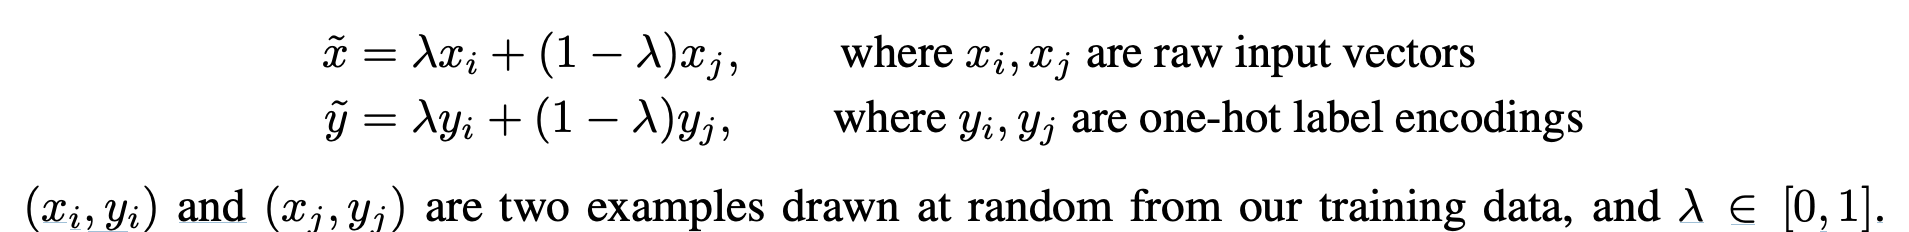

#### Αξιολόγηση του μοντέλου στο CIFAR-C

Για να καταλάβουμε περισσότερο τη χρησιμότητα του mixup και γενικότερα της επαύξησησς της κατανομής των δεδομένων εκπαίδευσης θα εκπαιδεύσουμε πάλι το μοντέλο μας στο CIFAR αλλά θα το κάνουμε evaluate στο CIFAR-C.

ΤοCIFAR-C παριέχει διάφορα corruptions (adversarial examples) στις εικόνες του αρχικού dataset, κάτι που το καθιστά πιο κοντά σε μια ρεαλιστική αξιολόγηση του μοντέλου.

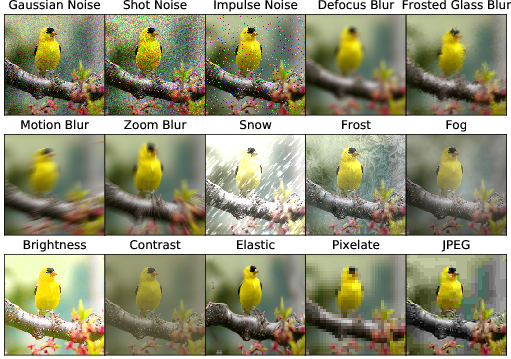


Επιλέγουμε το μοντέλο 28 - 10 με το dropout (παρόλο που η χρήση του dropout μειώνει κατά πολύ λίγο το accuracy) καθώς έχει μικρότερο cross entropy loss και σύμφωνα με το paper θεωρούμε πως μπορεί να γενικεύει καλύτερα. Το mixup πραγματοποιείται όπως ακριβώς ορίζεται παραπάνω. Το λ επιλέγεται από μια κατανομή Β(0.4,0.4). Η επιλογή αυτών των παραμέτρων έχει να κάνει με το γεγονός ότι είναι πιθανότερο να επιλέξεθ μία τιμή κοντά στο 0 ή το 1, παρά στο 0.5. Αυτό έχει ως αποτέλεσμα η mixed εικόνα να είναι πιο κοντά στην μία η στην άλλη παρά να αποτελεί ένα σχεδόν ισόποσο μείγμα.

In [13]:
#### GRADED CELL ####

# Complete the following code and run the cell


class CIFAR_Dataset(Dataset):
    def __init__(self, data_dir, train, transform, mixup):
        self.data_dir = data_dir
        self.train = train
        self.transform = transform
        self.data = []
        self.targets = []
        self.mixup = mixup

        # Loading all the data depending on whether the dataset is training or testing
        if self.train:
            for i in range(5):
                with open(data_dir + 'data_batch_' + str(i+1), 'rb') as f:
                    entry = pickle.load(f, encoding='latin1')
                    self.data.append(entry['data'])
                    self.targets.extend(entry['labels'])
        else:
            with open(data_dir + 'test_batch', 'rb') as f:
                entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                self.targets.extend(entry['labels'])

        # Reshape it and turn it into the HWC format which PyTorch takes in the images
        # Original CIFAR format can be seen via its official page
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Create a one hot label
        label = torch.zeros(10)
        label[self.targets[idx]] = 1.

        # Transform the image by converting to tensor and normalizing it
        if self.transform:
            image = transform(self.data[idx])

        # If data is for training, perform mixup, only perform mixup roughly on 1 for every 5 images
        if self.train and idx > 0 and self.mixup and idx%5 == 0:

            # Choose another image/label randomly
            mixup_idx = random.randint(0, len(self.data)-1)
            mixup_label = torch.zeros(10)
            mixup_label[self.targets[mixup_idx]] = 1.
            if self.transform:
                mixup_image = transform(self.data[mixup_idx])

            # Select a random number from the given beta distribution
            # Mixup the images accordingly
            ### Graded Part ###
            lam = np.random.beta(0.4, 0.4)
            image = lam * image + (1 - lam) * mixup_image
            label = lam * label + (1 - lam) * mixup_label



        return image, label

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]

In [15]:
# Evaluation scripts


def val_cifar(test_loader, net):
    """Evaluate network on given dataset."""
    net.eval()
    total_loss = 0.
    total_correct = 0
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)

            #targets = targets.cuda(non_blocking=True).long()
            #images = images.cuda(non_blocking=True).float()
            logits = net(images)
            pred = logits.data.max(1)[1]
            #total_correct += pred.eq(targets.data).sum().item()
            total_correct += int((pred == torch.argmax(targets, dim=1)).float().sum())
    #print("len(test_loader.dataset)", len(test_loader.dataset))
    return total_correct / len(test_loader.dataset)




# def test_cifar(test_loader, net):
#     """Evaluate network on given dataset."""
#     net.eval()
#     params = list(net.parameters())
#     total_loss = 0.
#     total_correct = 0
#     with torch.no_grad():
#         for images, targets in test_loader:
#             images = images.to(device)
#             targets = targets.to(device)
#             logits = net(images)

#             loss = F.cross_entropy(logits, targets)
#             pred = logits.data.max(1)[1]
#             total_loss += float(loss.data)
#             total_correct += pred.eq(targets.data).sum().item()
#     #print("len(test_loader.dataset)", len(test_loader.dataset))
#     return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset)

def test_cifar(test_loader, net):
    net.eval()
    total_loss = 0.
    total_correct = 0
    confidences = []  # Store confidence scores here
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = targets.to(device)
            logits = net(images)
            loss = F.cross_entropy(logits, targets)
            pred = logits.data.max(1)[1]
            total_loss += float(loss.data)
            total_correct += pred.eq(targets.data).sum().item()
            probs = F.softmax(logits, dim=1)
            conf, _ = torch.max(probs, dim=1)
            confidences.extend(conf.cpu().numpy())  # Add confidence scores
    avg_loss = total_loss / len(test_loader.dataset)
    avg_accuracy = total_correct / len(test_loader.dataset)
    return avg_loss, avg_accuracy, np.array(confidences)



def test_c_cifar(net):
    """Evaluate network on given corrupted dataset."""
    base_path = '/content/drive/My Drive/Lab_DL_ex1/data/cifar/CIFAR-10-C/'
    normalize = transforms.Normalize([0.5] * 3, [0.5] * 3)
    test_transform = transforms.Compose(
        [transforms.ToTensor(), normalize])
    test_data = datasets.CIFAR10(
        '/content/drive/My Drive/Lab_DL_ex1/data/cifar/', train=False, transform=test_transform)

    all_confidences = []

    corruption_accs = []
    Weather_accs = []
    Blur_accs = []
    Noise_accs = []
    Digital_accs = []
    weather_corr = ['snow', 'frost', 'fog']
    blur_corr = ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur']
    noise_corr = ['gaussian_noise', 'shot_noise', 'impulse_noise']
    digital_corr = ['brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')[-10000:]  # take the level 5 severity only
        #pdb.set_trace()
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy')[-10000:])

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=batch_size,
            shuffle=False,
            # num_workers=4,
            pin_memory=True)
        test_loss, test_acc, confidences = test_cifar(test_loader, net)
        corruption_accs.append(test_acc)
        all_confidences.append(confidences)  # Collect confidence scores for analysis

        if corruption in weather_corr:
            Weather_accs.append(test_acc)
        elif corruption in blur_corr:
            Blur_accs.append(test_acc)
        elif corruption in noise_corr:
            Noise_accs.append(test_acc)
        elif corruption in digital_corr:
            Digital_accs.append(test_acc)


        #print('{}\n\tTest Loss {:.3f} | Test Acc {:.3f}'.format(
        #    corruption, test_loss, test_acc))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Weather', np.mean(np.array(Weather_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Blur', np.mean(np.array(Blur_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Noise', np.mean(np.array(Noise_accs))))
    print('{}\n\t Test Acc {:.3f}'.format(
        'Digital', np.mean(np.array(Digital_accs))))
    all_accs = []
    all_accs.append(np.mean(np.array(Weather_accs)))
    all_accs.append(np.mean(np.array(Blur_accs)))
    all_accs.append(np.mean(np.array(Noise_accs)))
    all_accs.append(np.mean(np.array(Digital_accs)))

    return np.mean(corruption_accs), all_confidences


In [16]:
# Utils scripts

def save_checkpoint(state, dataset, exp_name, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "runs/%s/%s/" % (dataset, exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def get_lr(step, total_steps, lr_max, lr_min):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))
def bceloss(x, y):
    eps = 1e-6
    return -torch.mean(y * torch.log(x + eps) + (1 - y) * torch.log(1 - x + eps))


t =  391
Epoch  0
Validation set acc 0.3081
Weather
	 Test Acc 0.263
Blur
	 Test Acc 0.329
Noise
	 Test Acc 0.240
Digital
	 Test Acc 0.283
Average Cifar-C accuracy (0.28254666666666667, [array([0.8340769 , 1.        , 1.        , ..., 0.99968517, 0.67558616,
       0.984584  ], dtype=float32), array([0.9023915 , 1.        , 1.        , ..., 0.99770206, 0.80303884,
       0.99361056], dtype=float32), array([0.41009295, 1.        , 0.9999999 , ..., 0.72720414, 0.94664866,
       0.98413646], dtype=float32), array([0.98615634, 1.        , 0.9097635 , ..., 0.97982556, 0.65518516,
       0.9999331 ], dtype=float32), array([0.39808738, 1.        , 0.94649583, ..., 0.9874769 , 0.92442644,
       0.9995314 ], dtype=float32), array([0.83897626, 1.        , 0.7571115 , ..., 0.8334445 , 0.5708471 ,
       0.99945384], dtype=float32), array([0.9423182 , 1.        , 0.3133827 , ..., 0.98356897, 0.684662  ,
       0.9999585 ], dtype=float32), array([0.9951109 , 1.        , 0.99957186, ..., 0.776131 

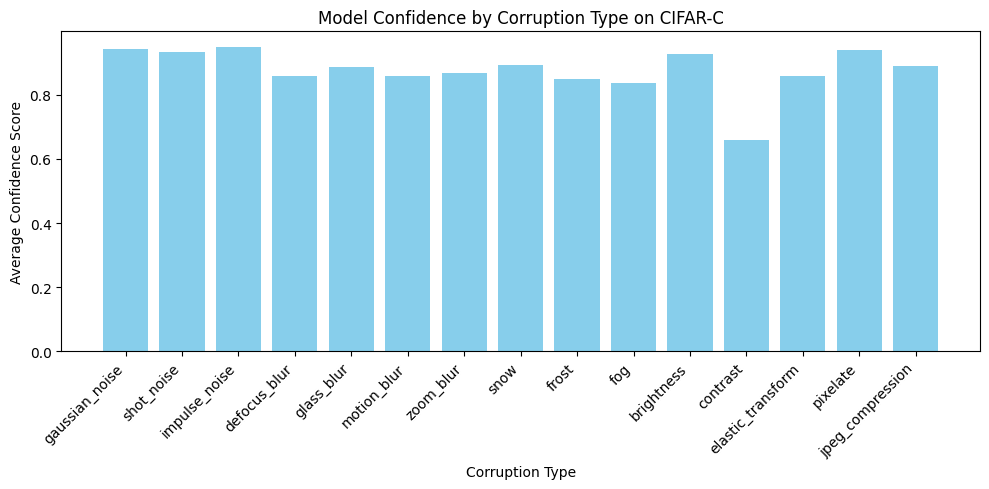

In [ ]:
#### GRADED CELL ####

# Κάντε train το καλύτερο μοντέλο που βρήκατε (και αποθηκεύσατε) στα βήματα 1 και 2 χωρίς το mixup
# Hint


num_epochs = 30

num_iters = 391 * num_epochs  # number of total epochs to run

batch_size = 128

print_freq = 391 # evaluation frequency (and log) (every epoch)

layers =  28 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = 0.3  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

criterion = nn.CrossEntropyLoss().cuda()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 1, transform, False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 0, transform, False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train loop
train_loader_iter = iter(train_loader)

counter_k = 0

epoch = 0
for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    #input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()
    imgs = input.to(device)
    labels = target.to(device)
    preds = model(imgs)
    preds = nn.Softmax(dim=1)(preds)
    loss = criterion(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_freq == 0 and t >= print_freq:
        print("t = ", t)
        prec1 = val_cifar(val_loader, model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        # logfile.write('validation set acc: ' + str(prec1) + '\n')
        print('Average Cifar-C accuracy {}'.format(test_c_cifar(model)))
        epoch += 1

_, confidences = test_c_cifar(model)
avg_confidences = [np.mean(conf) for conf in confidences]

plt.figure(figsize=(10, 5))
plt.bar(CORRUPTIONS, avg_confidences, color='skyblue')
plt.xlabel('Corruption Type')
plt.ylabel('Average Confidence Score')
plt.title('Model Confidence by Corruption Type on CIFAR-C')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Παρατηρούμε πως το accuracy στο CIFAR-C dataset δεν είναι τόσο υψηλό όσο προηγουμένως γεγονός που υποδεικνύει πως το μοντέλο δεν γενικεύει καλά σε τροποποιημένα δεδομένα. Μάλιστα παρατηρούμε ότι για μεγάλο αριθμό εποχών το accuracy γίνεται χειρότερο, γεγονός που οφείλεται στο μεγαλύτερο overfitting που κάνει το μοντέλο στο CIFAR dataset. Αυτό είναι λογικό γιατί το μοντέλο μας, το οποίο έχει εκπαιδευτεί σε clean δεδομένα, δεν μπορεί να χειριστεί θορυβώδη, ή παραλλαγμένα δεδομένα εξίσου καλά, αφού δεν έχει εκπαιδευτεί σε αυτά. Επιπλέον, παρατηρούμε πως το accuracy δεν συγκλίνει κάπου αλλά υπάρχουν ταλαντώσεις. Αυτό μπορεί να οφείλεται στον μικρό αριθμό εποχών ή σε παραμέτρους της εκπαίδευσης όπως το learning rate και το batch size ή πολύ απλά στο γεγονός πως το μοντέλο δεν έχει εκπαιδευτεί στα κατάλληλα δεδομένα. Θα προσπαθήσουμε να λύσουμε αυτό το πρόβλημα με χρήση του mixup.

In [17]:
#### GRADED CELL ####
# Train your best model with mixup and test on CIFAR-C

# Model parameters


num_epochs = 30

num_iters = 391 * num_epochs  # number of total epochs to run

batch_size = 128

print_freq = 391 # evaluation frequency (and log) (every epoch)

layers =  28 # total number of layers of wrn (wide residual network)
num_classes = 10   # Number of classes of th CIFAR dataset
widen_factor = 10
droprate = 0.3  #  Dropout probability for regularization
lr = 0.1  # learning rate
weight_decay = 0.0005

model = WideResNet(layers, num_classes, widen_factor, droprate)

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9, nesterov=True,
                                    weight_decay=weight_decay)
# scheduler_theta = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60)
scheduler = torch.optim.lr_scheduler.LambdaLR(
  optimizer,
  lr_lambda=lambda step: get_lr(
      step,
      num_iters,
      1,
      1e-6 / lr))

criterion = nn.CrossEntropyLoss().cuda()

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 1, transform, True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CIFAR_Dataset('/content/drive/My Drive/Lab_DL_ex1/data/cifar/cifar-10-batches-py/', 0, transform, True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

t =  391
Epoch  0
Validation set acc 0.3595
Weather
	 Test Acc 0.243
Blur
	 Test Acc 0.318
Noise
	 Test Acc 0.316
Digital
	 Test Acc 0.297
Average Cifar-C accuracy (0.29555333333333333, [array([0.5505017 , 1.        , 1.        , ..., 0.7947412 , 0.92945755,
       0.99329066], dtype=float32), array([0.61591005, 1.        , 0.9999999 , ..., 0.9769032 , 0.9099398 ,
       0.99285126], dtype=float32), array([0.83880997, 1.        , 0.9999999 , ..., 0.39719754, 0.61681116,
       0.6055657 ], dtype=float32), array([0.8375216 , 0.9999908 , 0.9856726 , ..., 0.99287206, 0.7080485 ,
       0.99867237], dtype=float32), array([0.6506282 , 0.9999994 , 0.9976802 , ..., 0.9638248 , 0.9217113 ,
       0.99977297], dtype=float32), array([0.75538826, 1.        , 0.9994892 , ..., 0.9892586 , 0.9529697 ,
       0.9994881 ], dtype=float32), array([0.8647687 , 0.99999976, 0.9899831 , ..., 0.9922726 , 0.8731331 ,
       0.9991673 ], dtype=float32), array([0.9059969 , 0.9978136 , 0.5259215 , ..., 0.9860176

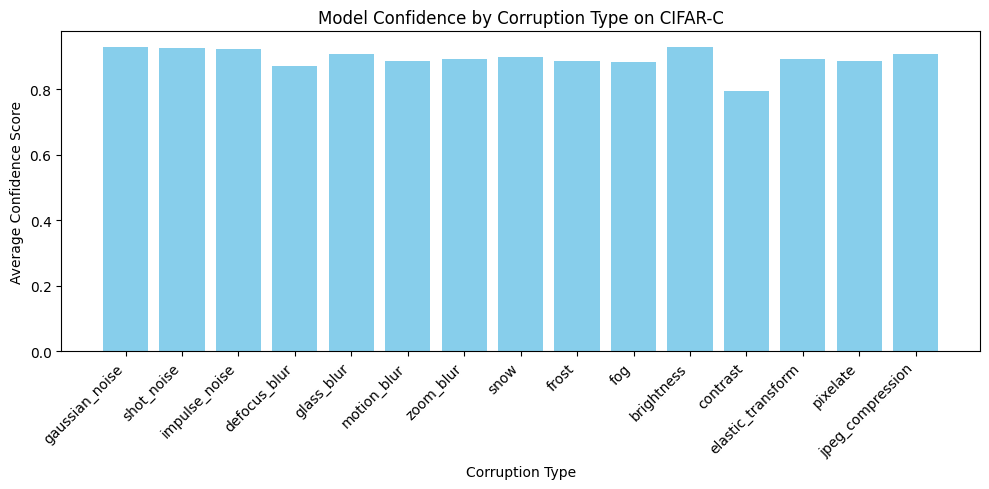

In [18]:
# Train loop
train_loader_iter = iter(train_loader)

counter_k = 0

epoch = 0
for t in range(0, num_iters):

    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    try:
        input, target = next(train_loader_iter)
    except:
        train_loader_iter = iter(train_loader)
        input, target = next(train_loader_iter)
    #input, target = input.cuda(non_blocking=True).float(), target.cuda(non_blocking=True).long()
    imgs = input.to(device)
    labels = target.to(device)
    preds = model(imgs)
    preds = nn.Softmax(dim=1)(preds)
    loss = criterion(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if t % print_freq == 0 and t >= print_freq:
        print("t = ", t)
        prec1 = val_cifar(val_loader, model)
        print("Epoch ", epoch)
        print("Validation set acc", prec1)
        # logfile.write('validation set acc: ' + str(prec1) + '\n')
        print('Average Cifar-C accuracy {}'.format(test_c_cifar(model)))
        epoch += 1

_, confidences = test_c_cifar(model)
avg_confidences = [np.mean(conf) for conf in confidences]

plt.figure(figsize=(10, 5))
plt.bar(CORRUPTIONS, avg_confidences, color='skyblue')
plt.xlabel('Corruption Type')
plt.ylabel('Average Confidence Score')
plt.title('Model Confidence by Corruption Type on CIFAR-C')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Παρατηρούμε πως το mixup όπως χρησιμοποιήθηκε δεν βελτιώνει το accuracy και παρατηρούνται τα ίδια προβλήματα που αναφέρθηκαν προηγουμένως.  Αυτό οφείλεται πιθανότατα στην φύση των corruptions του CIFAR-C dataset. Το mixup που χρησιμοποιήσαμε εκπαιδεύει το μοντέλο σε γραμμικά interpolations των δεδομένων εκπαίδευσης. Ωστόσο, τα corruptions του CIFAR-C είναι μη γραμμικά και περίπλοκα με αποτέλεσμα να μην μπορούν να αποτυπωθούν από τα δεδομένα που παράγει το mixup. Με λίγα λόγια, τα συνθετικά δεδομένα που παράγονται από το mixup του CIFAR, δεν "μιμούνται" επαρκώς τις αλλαγές που εισάγονται από το CIFAR-C. Για να είχαμε καλύτερα αποτελέσματα θα έπρεπε να χρησιμοποιήσουμε μια επαύξηση δεδομένων η οποία θα εισήγαγε θόρυβο, blur και άλλα artifacts που παρατηρούνται στο CIFAR-C.

In [ ]:
#### GRADED CELL #### (Bonus)

# Plot the confidence scores for CIFAR-C with WRN model
# trained with and without mixup and comment


Τα plots με τα confidence scores για κάθε τύπο corruption τόσο με mixup όσο και χωρίς φαίνονται παραπάνω. Και στις δύο περιπτώσεις παρατηρούμε πως ενώ το accuracy είναι χαμηλό, τα confidence scores είναι αρκετά υψηλά. Αυτό σχετιέζεται με όσα περιγράψαμε παραπάνω και κυρίως την αδυναμία του μοντέλου να κάνει generalize επιτυχώς. Σε συνέχεια όσων προαναφέρθηκαν, το μοντέλο φαίνεται πως "απομνημονέυει" κάποια training data ή χαρακτηριστικά αυτών και δεν γενικεύει στα corruptions του CIFAR-C. Το αποτέλεσμα είναι να δημιουργείται ένα overconfidence το οποίο οφείλεται στο overfitting στα χαρακτηριστικά των training data τα οποία δεν απαντώνται στα test data.